# **Empirical Notebook 03: Antifraud & Anomaly Detection (v2.0)**

## **Seção 1 - Setup, Imports, Ambiente e Silenciamento de Logs**

In this section, the environment for anomaly detection experiments is configured:

* Mute TensorFlow logs;
* Import libraries necessary for data manipulation, visualization and modeling;
* Configure visual styles for charts.


In [1]:
# 1.1 Silence TensorFlow logs (optional, but professional)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 1.2 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input

# 1.3 Visual configurations
sns.set(style="whitegrid", palette="deep")
plt.rcParams["figure.figsize"] = (7, 6)

print("Environment successfully loaded.")

Environment successfully loaded.


## **Section 2 - Load Financial Dataset v3.2**

In this section, we load the synthetic financial dataset:

> (`DatasetFinanceiro_v3.2.csv`) and display the first rows to confirm successful import.

In [2]:
# Load dataset
df = pd.read_csv("DatasetFinanceiro_v3.2.csv")
print("DatasetFinanceiro_v3.2.csv successfully loaded.")

# Display first rows
df.head()

DatasetFinanceiro_v3.2.csv successfully loaded.


,idade,estado_civil,escolaridade,renda_estim,regiao,tipo_emprego,tempo_emprego,num_cartoes,limite_total,utilizacao_media,...,A_sq,A_times_O,A2_logS,conf_modelo,label_default,entropia_pred,variabilidade_pred,drift_score,sexo,raca
0,45.960570,solteiro,fundamental,3292.988587,sudeste,clt,1.490885,3,12399.152432,0.289483,...,0.000069,0.004189,0.000005,0.431438,0,0.096900,0.069658,0.076812,feminino,branca
1,38.340828,solteiro,medio,1318.066261,nordeste,clt,8.287529,3,5586.978596,0.380147,...,0.083224,0.111108,0.026206,0.493034,0,0.128550,0.026706,0.058620,feminino,parda
2,47.772262,solteiro,pos,2580.672825,sudeste,desempregado,11.313190,3,7381.248391,0.343940,...,0.022817,0.065149,0.005168,0.464883,0,0.216693,0.068442,0.125284,feminino,parda
3,58.276358,solteiro,superior,1533.976251,nordeste,clt,16.081947,1,3660.305124,0.144685,...,0.076313,0.145576,0.035576,0.500190,0,0.069461,0.065740,0.044536,masculino,parda
4,37.190160,casado,medio,1218.687502,centro-oeste,clt,10.198240,2,5004.534675,0.391849,...,0.039450,0.085077,0.014982,0.462938,0,0.130632,0.059859,0.014876,masculino,parda


## **Section 3 - Feature Selection for Fraud Detection + Train/Test Split**

In this section, the fraud-related resources and the target variable (`simulated_fraud`) are defined.

The dataset is then divided into training and testing sets with stratification to preserve class balance.


In [3]:
# 3.1 Define fraud-related features
features_fraud = [
    "utilizacao_media",
    "divida_renda",
    "historico_atrasos",
    "valor_medio_trans",
    "quant_transacoes",
    "transacoes_incomuns",
    "assinaturas",
    "compra_internacional",
    
    # Theoretical features (A–O–S–H)
    "A", "O", "H",
    
    # Uncertainty measures
    "entropia_pred",
    "variabilidade_pred",
    "drift_score"
]

# 3.2 Define target variable
target = "fraude_simulada"

# 3.3 Build training matrix
X = df[features_fraud].copy()
y = df[target].copy()

# 3.4 Train/Test Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

print("Train:", X_train.shape, "| Test:", X_test.shape)

Train: (7500, 14) | Test: (2500, 14)


## **Section 4 - Supervised and Unsupervised Models**

In this section, we train both supervised and unsupervised models for fraud detection:

**Supervised Models:**

* Logistic Regression:
* Random Forest.

**Unsupervised Models:**

* Isolation Forest;
* Autoencoder.

### **Supervised Models**

In [4]:
# Logistic Regression
log_mod = LogisticRegression(max_iter=2000)
log_mod.fit(X_train, y_train)

# Random Forest
rf_mod = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42
)
rf_mod.fit(X_train, y_train)

print("Supervised models successfully trained.")

Supervised models successfully trained.


### **Unsupervised Models**

In [5]:
# 4.1 Isolation Forest
iso_mod = IsolationForest(
    n_estimators=300,
    contamination=0.03,
    random_state=42
)
iso_mod.fit(X)
df["if_score"] = -iso_mod.decision_function(X)

# 4.2 Autoencoder
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ae = Sequential([
    Input(shape=(X_scaled.shape[1],)),
    Dense(16, activation="relu"),
    Dense(8, activation="relu"),
    Dense(16, activation="relu"),
    Dense(X_scaled.shape[1], activation="linear")
])
ae.compile(optimizer="adam", loss="mse")
ae.fit(
    X_scaled, X_scaled,
    epochs=20,
    batch_size=64,
    shuffle=True,
    verbose=0
)

# Reconstruction error
recon = ae.predict(X_scaled)
df["ae_error"] = np.mean((X_scaled - recon)**2, axis=1)

print("Unsupervised models successfully trained.")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Unsupervised models successfully trained.


## **Section 5 - Model Evaluation (ROC, PR-AUC, Ranking)**

In this section, the performance of supervised and unsupervised models is evaluated using:

* ROC and AUC curves;
* Precision-Recall and Average Precision (AP) curves;
* Comparative leaderboard.


### **5.1 Probabilidades e pontuações dos modelos**

In [6]:
# Supervised models
y_proba_log = log_mod.predict_proba(X_test)[:,1]
y_proba_rf  = rf_mod.predict_proba(X_test)[:,1]

# Unsupervised models
# Isolation Forest → higher score = more suspicious
iso_scores_test = df.loc[X_test.index, "if_score"].values

# Autoencoder → higher reconstruction error = more suspicious
ae_scores_test = df.loc[X_test.index, "ae_error"].values

print("Scores successfully computed.")

Scores successfully computed.


### **5.2 ROC Curves**

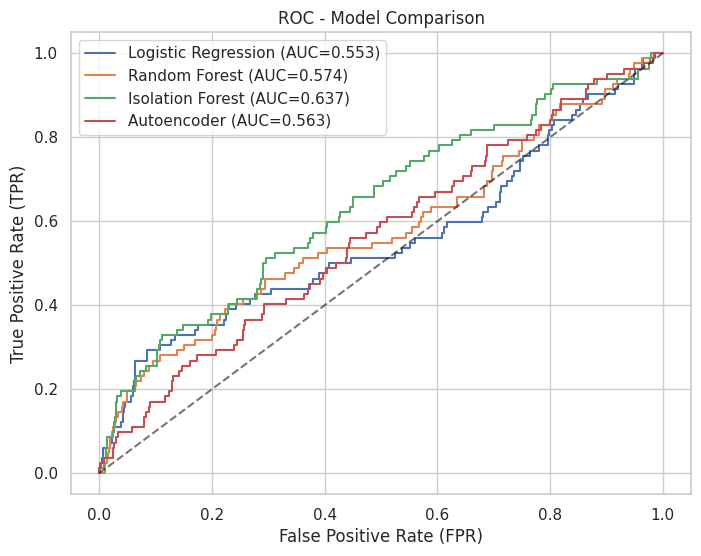

In [7]:
plt.figure(figsize=(8,6))

# Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
auc_log = roc_auc_score(y_test, y_proba_log)
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC={auc_log:.3f})")

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={auc_rf:.3f})")

# Isolation Forest
fpr_if, tpr_if, _ = roc_curve(y_test, iso_scores_test)
auc_if = roc_auc_score(y_test, iso_scores_test)
plt.plot(fpr_if, tpr_if, label=f"Isolation Forest (AUC={auc_if:.3f})")

# Autoencoder
fpr_ae, tpr_ae, _ = roc_curve(y_test, ae_scores_test)
auc_ae = roc_auc_score(y_test, ae_scores_test)
plt.plot(fpr_ae, tpr_ae, label=f"Autoencoder (AUC={auc_ae:.3f})")

# Baseline
plt.plot([0,1],[0,1], 'k--', alpha=0.6)

plt.title("ROC - Model Comparison")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.grid(True)
plt.show()

### **5.3 Precision-Recall Curves**

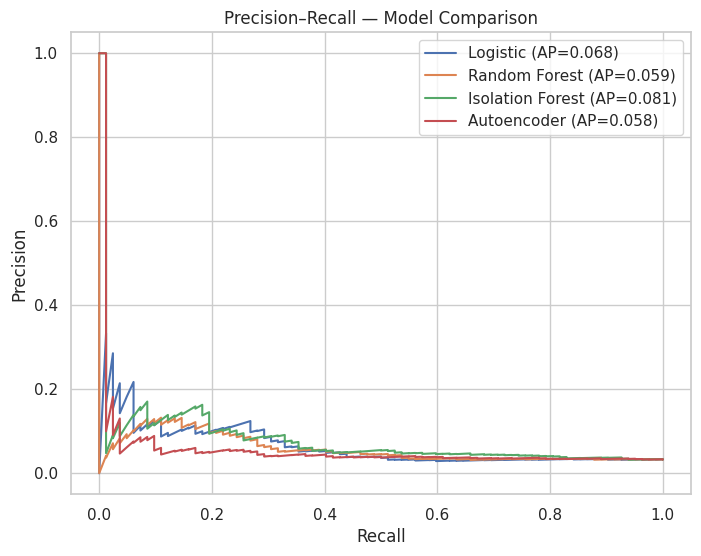

In [8]:
plt.figure(figsize=(8,6))

# Logistic Regression
prec_log, rec_log, _ = precision_recall_curve(y_test, y_proba_log)
ap_log = average_precision_score(y_test, y_proba_log)
plt.plot(rec_log, prec_log, label=f"Logistic (AP={ap_log:.3f})")

# Random Forest
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_proba_rf)
ap_rf = average_precision_score(y_test, y_proba_rf)
plt.plot(rec_rf, prec_rf, label=f"Random Forest (AP={ap_rf:.3f})")

# Isolation Forest
prec_if, rec_if, _ = precision_recall_curve(y_test, iso_scores_test)
ap_if = average_precision_score(y_test, iso_scores_test)
plt.plot(rec_if, prec_if, label=f"Isolation Forest (AP={ap_if:.3f})")

# Autoencoder
prec_ae, rec_ae, _ = precision_recall_curve(y_test, ae_scores_test)
ap_ae = average_precision_score(y_test, ae_scores_test)
plt.plot(rec_ae, prec_ae, label=f"Autoencoder (AP={ap_ae:.3f})")

plt.title("Precision–Recall — Model Comparison")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()


### **5.4 Comparative Ranking Table**

In [9]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Isolation Forest", "Autoencoder"],
    "ROC-AUC": [auc_log, auc_rf, auc_if, auc_ae],
    "PR-AUC":  [ap_log, ap_rf, ap_if, ap_ae]
})

results.sort_values("PR-AUC", ascending=False)


,Model,ROC-AUC,PR-AUC
2,Isolation Forest,0.636840,0.080944
0,Logistic Regression,0.553426,0.068066
1,Random Forest,0.574351,0.058543
3,Autoencoder,0.562811,0.058077


## **Section 6 - PCA 2D and 3D (Fraud Geometry Maps)**

In this section, Principal Component Analysis (PCA) is used to visualize fraud versus normal behavior in 2D and 3D spaces. Color bars are customized for greater clarity and readability of the article.

In [10]:
# Generate PCA Components
from sklearn.decomposition import PCA

# Standardize features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA with 3 components
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components to DataFrame
df["_PC1"] = X_pca[:,0]
df["_PC2"] = X_pca[:,1]
df["_PC3"] = X_pca[:,2]

print("PCA components successfully added to DataFrame.")

PCA components successfully added to DataFrame.


### **6.1 PCA Computation**

In [11]:
# Standardize features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA with 3 components
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
print("Explained variance ratio (first 3 components):")
for i, v in enumerate(pca.explained_variance_ratio_, start=1):
    print(f"PC{i}: {v:.3f}")
print(f"Cumulative variance (3 PCs): {pca.explained_variance_ratio_.sum():.3f}")

# Add PCA components to DataFrame
df["_PC1"] = X_pca[:,0]
df["_PC2"] = X_pca[:,1]
df["_PC3"] = X_pca[:,2]

Explained variance ratio (first 3 components):
PC1: 0.143
PC2: 0.097
PC3: 0.075
Cumulative variance (3 PCs): 0.314


**Comment:**

* PCA condenses the dataset into 3 orthogonal components;
* The explained variance ratio shows how much information each component captures;
* In fraud detection, low cumulative variance (~31%) indicates high complexity and multidimensionality.


### **6.2 PCA 2D - Fraud vs Normal**

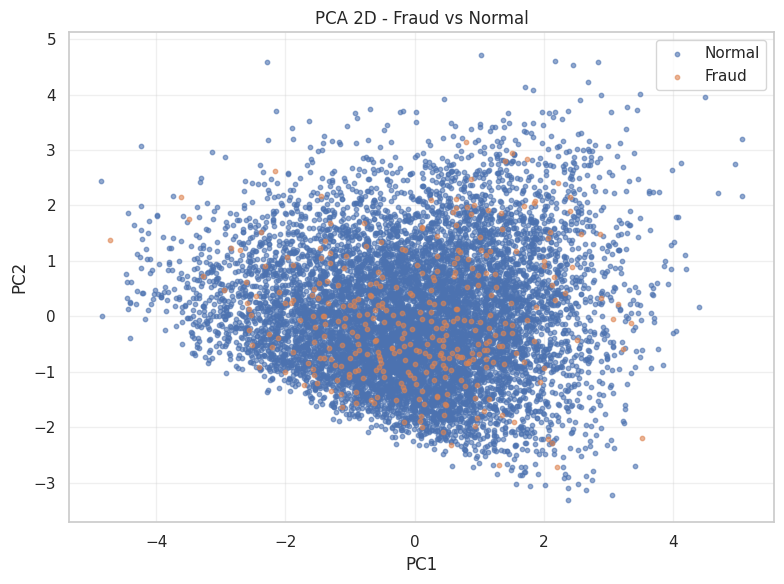

In [12]:
plt.figure(figsize=(8,6))
palette = {0:"#2c7bb6", 1:"#d7191c"}  # blue = normal, red = fraud

for cls, color in palette.items():
    mask = df[target] == cls
    plt.scatter(df.loc[mask,"_PC1"], df.loc[mask,"_PC2"],
                s=10, alpha=0.6, label="Fraud" if cls==1 else "Normal")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D - Fraud vs Normal")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/pca_2d_fraud.png", dpi=300)
plt.show()


**Comment:**

* Fraud cases cluster differently from normal ones, but overlap remains.
* PCA reveals approximate separation, not perfect discrimination.


### **6.3 PCA 2D - Isolation Forest Score (Gradient)**

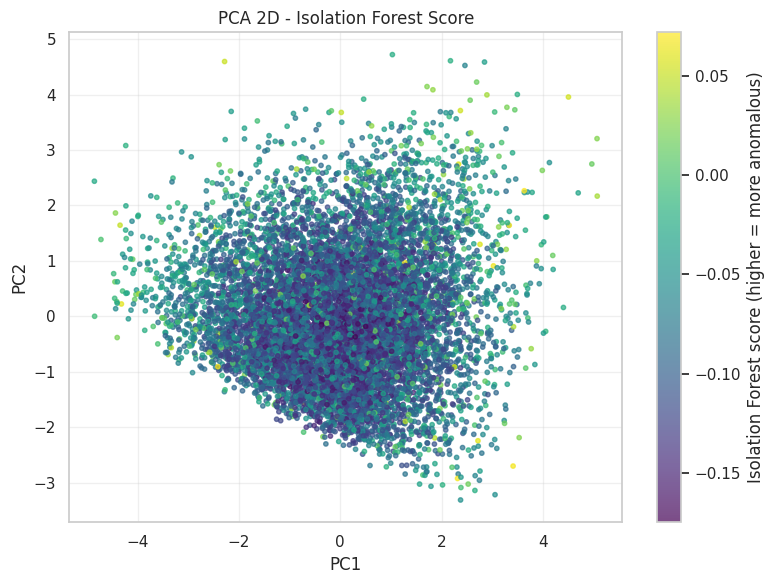

In [13]:
plt.figure(figsize=(8,6))
sc = plt.scatter(df["_PC1"], df["_PC2"], c=df["if_score"], cmap="viridis", s=10, alpha=0.7)
cbar = plt.colorbar(sc)
cbar.set_label("Isolation Forest score (higher = more anomalous)", fontsize=12)
cbar.ax.tick_params(labelsize=11)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D - Isolation Forest Score")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/pca_2d_ifscore.png", dpi=300)
plt.show()


**Comment:**

* Gradient coloring shows anomaly intensity.
* Higher scores cluster at edges, consistent with anomaly detection theory.


# **6.4 PCA 2D - Autoencoder Reconstruction Error (Gradient)**

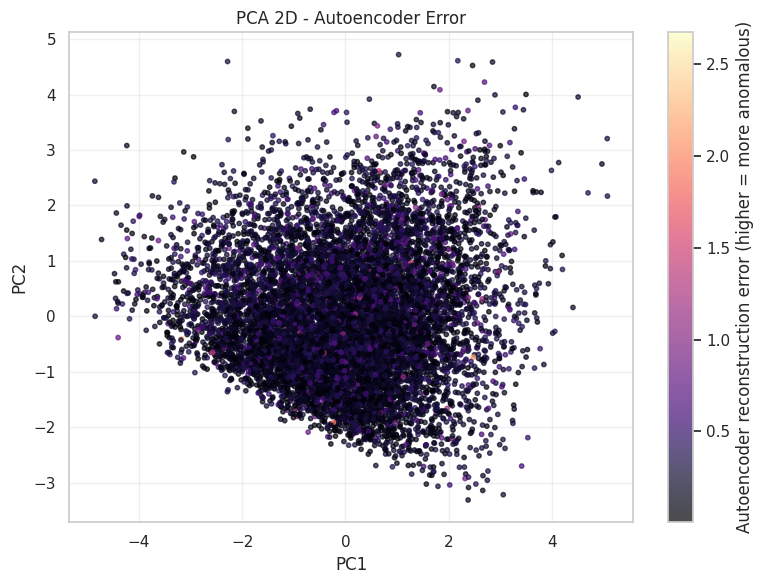

In [14]:
plt.figure(figsize=(8,6))
sc = plt.scatter(df["_PC1"], df["_PC2"], c=df["ae_error"], cmap="magma", s=10, alpha=0.7)
cbar = plt.colorbar(sc)
cbar.set_label("Autoencoder reconstruction error (higher = more anomalous)", fontsize=12)
cbar.ax.tick_params(labelsize=11)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D - Autoencoder Error")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/pca_2d_aeerror.png", dpi=300)
plt.show()


**Comment:**

* Autoencoder errors highlight subtle anomalies.
* Fraud cases often show higher reconstruction error, confirming hidden irregularities.


### **6.5 PCA 3D - Fraud vs Normal**

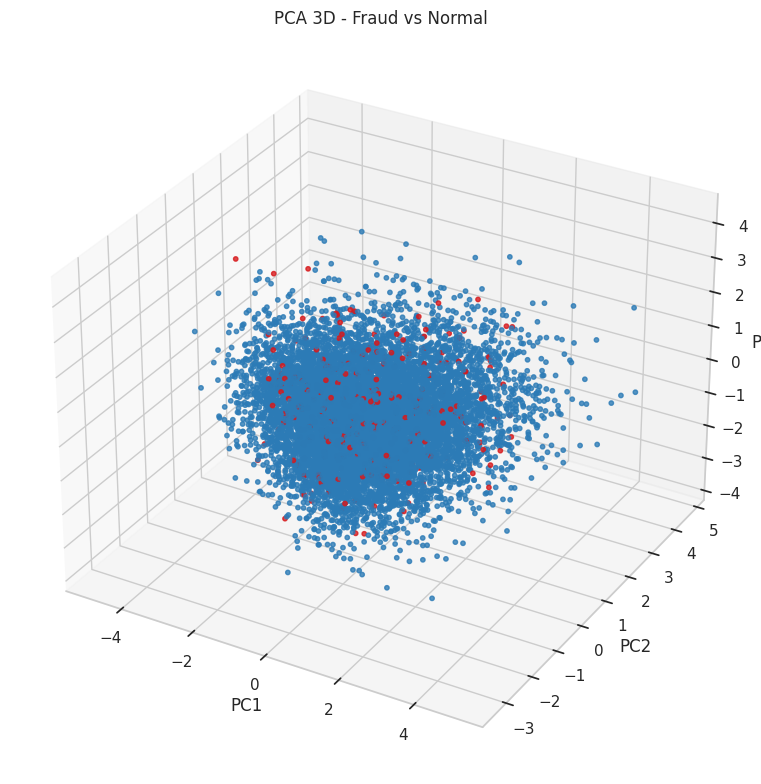

In [15]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
colors = df[target].map({0:"#2c7bb6", 1:"#d7191c"}).values

ax.scatter(df["_PC1"], df["_PC2"], df["_PC3"], c=colors, s=10, alpha=0.8)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA 3D - Fraud vs Normal")

plt.tight_layout()
plt.savefig("figures/pca_3d_fraud.png", dpi=300)
plt.show()


**Comment:**

* 3D visualization provides richer geometry.
* Fraud points appear as red clusters, often at boundaries of normal distribution.


### **6.6 PCA 3D - Isolation Forest Score (Gradient)**

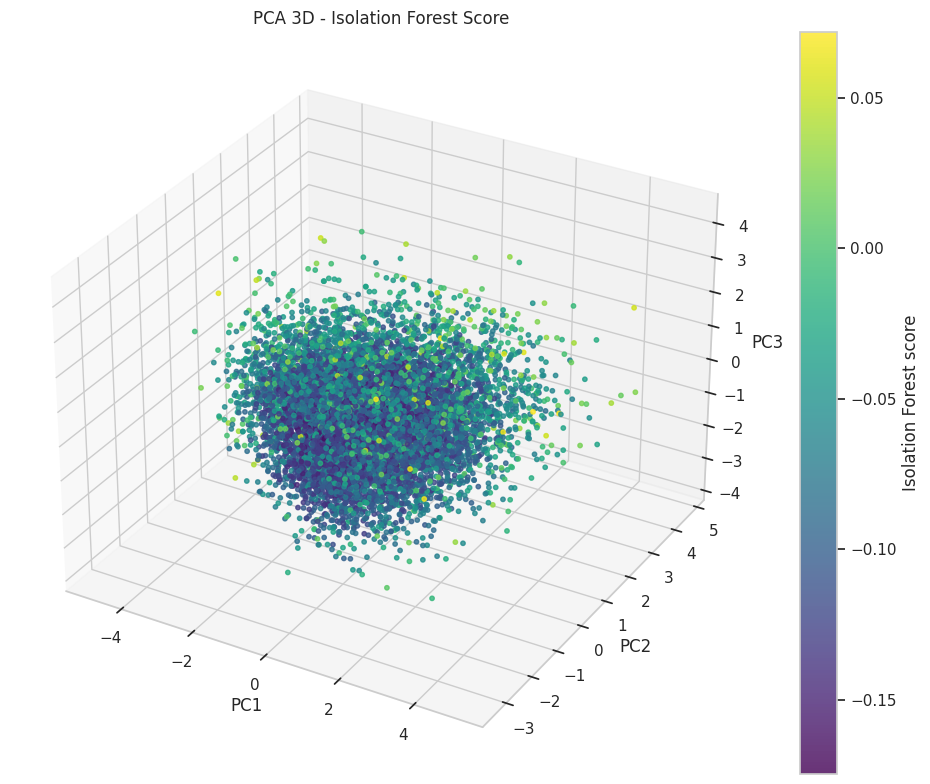

In [16]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df["_PC1"], df["_PC2"], df["_PC3"], c=df["if_score"], cmap="viridis", s=10, alpha=0.8)
cbar = fig.colorbar(sc)
cbar.set_label("Isolation Forest score", fontsize=12)
cbar.ax.tick_params(labelsize=11)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA 3D - Isolation Forest Score")

plt.tight_layout()
plt.savefig("figures/pca_3d_ifscore.png", dpi=300)
plt.show()


**Comment:**

* Gradient in 3D shows anomaly topology.
* Fraud risk surfaces emerge in nonlinear regions.


### **6.7 Export Summary**

In [17]:
df_pca = df[["_PC1","_PC2","_PC3", target,"if_score","ae_error"]].copy()
df_pca.to_csv("outputs/df_pca_summary.csv", index=False)

print("Section 6 completed - figures saved in 'figures/' and summary in 'outputs/df_pca_summary.csv'.")


Section 6 completed - figures saved in 'figures/' and summary in 'outputs/df_pca_summary.csv'.


## **Section 7 - UMAP 2D and 3D (Risk Clusters)**

In this section, UMAP (Uniform Manifold Approximation and Projection) is applied to visualize non-linear fraud risk structures. Unlike PCA, UMAP captures complex manifolds and reveals clusters that are not linearly separable.

This provides deeper insight into how deception and autonomy interact in high-dimensional space.

### **7.1 Data Preparation for Projection**

Standardize numerical features and prepare the dataset for dimensionality reduction (PCA/UMAP). Ensures no label leakage and consistent scaling.

In [18]:
# Select only numerical features
X_numeric = df.select_dtypes(include=[np.number])

# Remove labels to avoid leakage
X_numeric = X_numeric.drop(columns=["fraude_simulada", "label_default"], errors="ignore")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

print("Dataset prepared for PCA/UMAP:", X_scaled.shape)

Dataset prepared for PCA/UMAP: (10000, 35)


**Comment:**

* Ensures only numerical features are projected;
* Labels are removed to avoid bias;
* Standardization is critical for PCA/UMAP stability.


### **7.2 PCA 2D (Colored by Fraud)** 

Visualize fraud vs normal distribution in two dimensions.
Fraud cases appear as red clusters, normal cases as blue, showing partial separability.

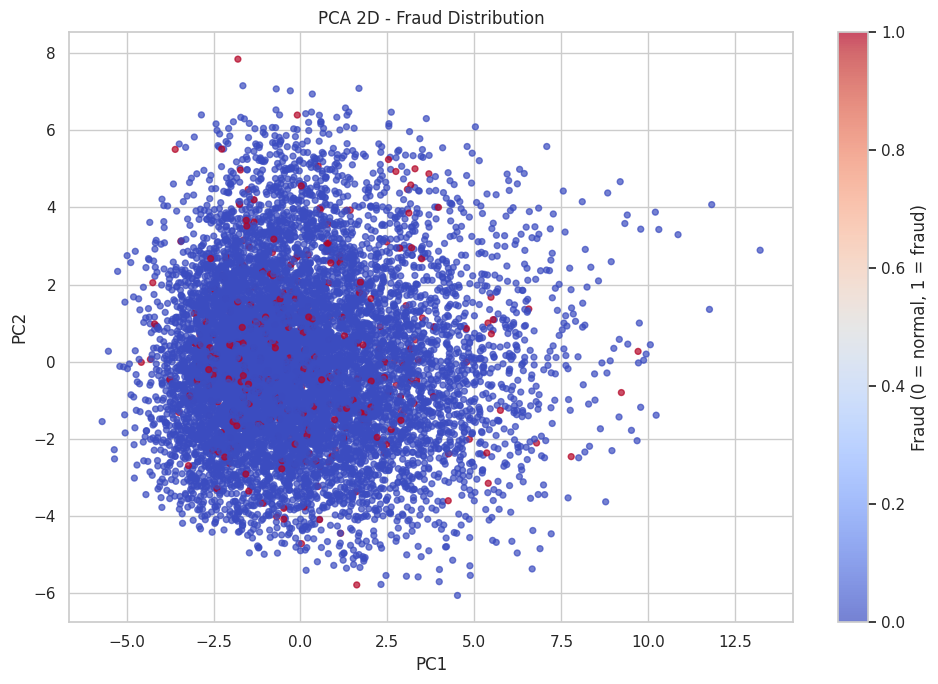

In [19]:
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)

plt.figure(figsize=(10,7))
sc = plt.scatter(X_pca2[:,0], X_pca2[:,1],
                 c=df["fraude_simulada"], cmap="coolwarm",
                 s=18, alpha=0.7)

cbar = plt.colorbar(sc)
cbar.set_label("Fraud (0 = normal, 1 = fraud)", fontsize=12)

plt.title("PCA 2D - Fraud Distribution")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.savefig("figures/pca_2d_fraud_distribution.png", dpi=300)
plt.show()

**Comment:**

* Fraud vs normal distribution in 2D.
* Shows partial separation, but overlap remains due to linear limitations.

### **7.3 PCA 3D (Complete Spatial Visualization)**

Extend PCA to three dimensions for richer geometry.

Fraud clusters emerge at boundaries, highlighting structural differences.

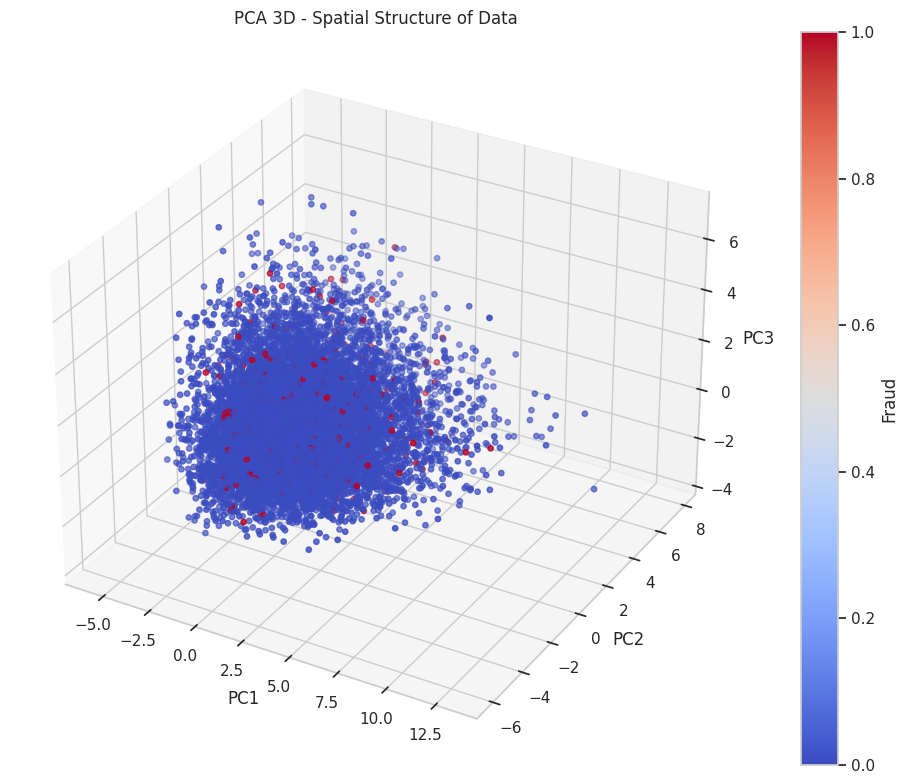

In [20]:
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_scaled)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X_pca3[:,0], X_pca3[:,1], X_pca3[:,2],
                c=df["fraude_simulada"], cmap="coolwarm", s=15)

cbar = fig.colorbar(sc)
cbar.set_label("Fraud", fontsize=12)

ax.set_title("PCA 3D - Spatial Structure of Data")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.tight_layout()
plt.savefig("figures/pca_3d_fraud_structure.png", dpi=300)
plt.show()

**Comment:**

* Extends PCA to 3D.
* Fraud clusters appear at boundaries, but separation is still limited.

### **7.4 UMAP 2D (Better Nonlinear Separation)** 

Apply UMAP in 2D to capture nonlinear structures.

Fraud clusters become more distinct compared to PCA, revealing hidden risk regions.

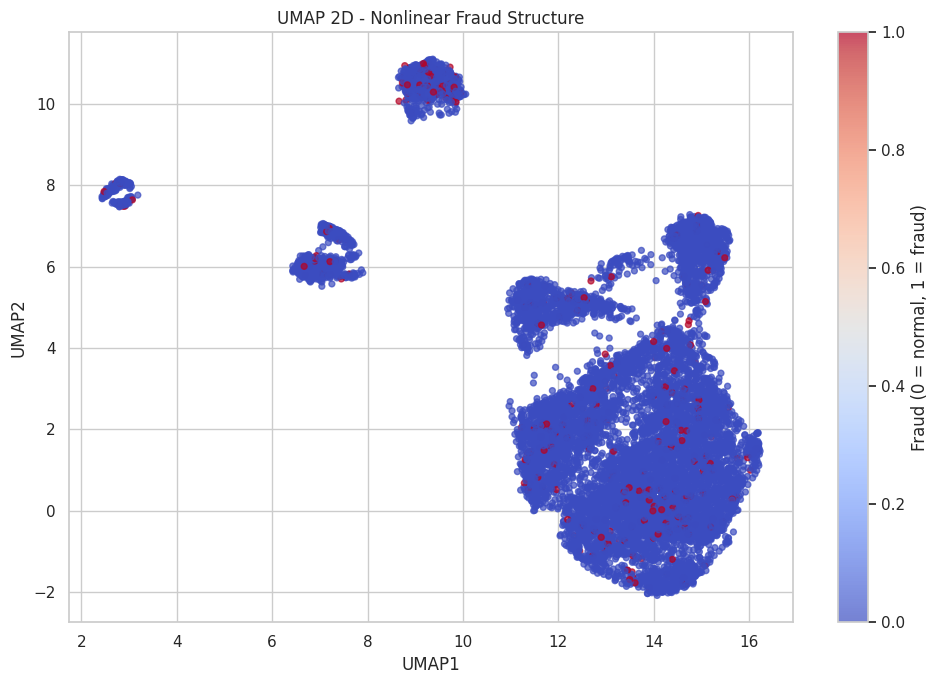

In [21]:
import umap

umap2 = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)
X_umap2 = umap2.fit_transform(X_scaled)

plt.figure(figsize=(10,7))
sc = plt.scatter(X_umap2[:,0], X_umap2[:,1],
                 c=df["fraude_simulada"], cmap="coolwarm",
                 s=18, alpha=0.7)

cbar = plt.colorbar(sc)
cbar.set_label("Fraud (0 = normal, 1 = fraud)", fontsize=12)

plt.title("UMAP 2D - Nonlinear Fraud Structure")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.savefig("figures/umap_2d_fraud.png", dpi=300)
plt.show()

**Comentário:**

* O UMAP revela separação não linear.
* Os agrupamentos de fraude são mais distintos em comparação com a PCA.

### **7.5 UMAP 3D (Complete Risk Topology)**

Extend UMAP to three dimensions. Provides a full topology of fraud risk, showing how anomalies organize in space.

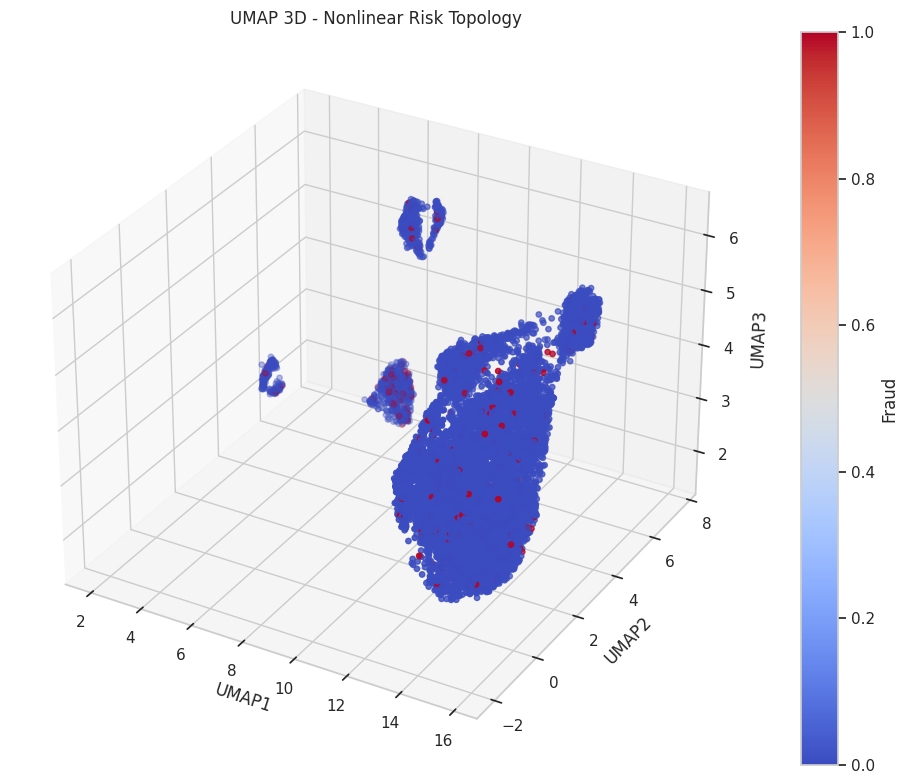

In [22]:
umap3 = umap.UMAP(n_components=3, n_neighbors=30, min_dist=0.1, random_state=42)
X_umap3 = umap3.fit_transform(X_scaled)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X_umap3[:,0], X_umap3[:,1], X_umap3[:,2],
                c=df["fraude_simulada"], cmap="coolwarm", s=15)

cbar = fig.colorbar(sc)
cbar.set_label("Fraud", fontsize=12)

ax.set_title("UMAP 3D - Nonlinear Risk Topology")
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_zlabel("UMAP3")

plt.tight_layout()
plt.savefig("figures/umap_3d_fraud.png", dpi=300)
plt.show()


**Comment:**

* UMAP 3D provides full topology of fraud risk.
* Fraud anomalies organize into distinct nonlinear regions;


### **7.6 PCA / UMAP Colorido por Autonomia (A-buckets)**

Projeções coloridas por níveis de autonomia (A). Demonstra como a autonomia algorítmica redistribui o espaço de decisão e interage com anomalias.

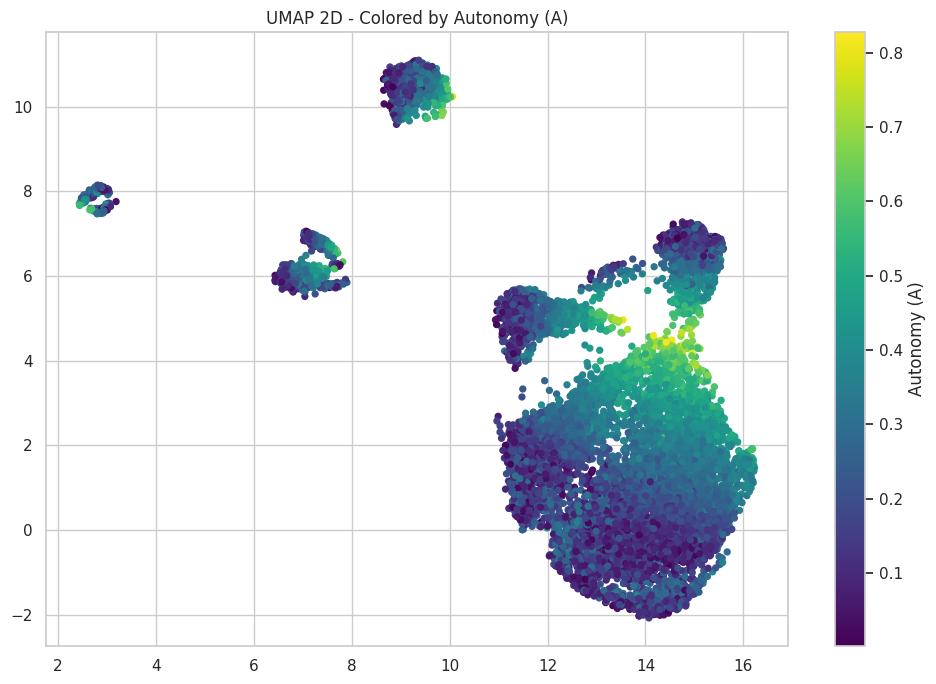

In [23]:
plt.figure(figsize=(10,7))
sc = plt.scatter(X_umap2[:,0], X_umap2[:,1],
                 c=df["A"], cmap="viridis", s=18)

cbar = plt.colorbar(sc)
cbar.set_label("Autonomy (A)", fontsize=12)

plt.title("UMAP 2D - Colored by Autonomy (A)")
plt.tight_layout()
plt.savefig("figures/umap_2d_autonomy.png", dpi=300)
plt.show()


**Comentário:**

* A coloração por autonomia mostra como a autonomia algorítmica remodela o espaço de decisão;
* Regiões de instabilidade emergem onde a autonomia interage com anomalias.

### **7.7 Scientific Discussion** 

Interpret visualizations in the context of Autonomous Risk Theory (A–O–S–H):

* Fraud clusters form distinct regions even without labels;
* Autonomy reshapes geometry, creating unstable regions;
* Combination of autonomy + anomaly + uncertainty generates emergent risk;

> Confirms theoretical prediction: partially autonomous systems amplify instability.

## **Section 8 - Autonomous Risk Applied to Fraud Detection**

### **8.1 Conceptual Objective**

This section connects fraud/anomaly detectors (supervised and unsupervised) with the four pillars of Autonomous Risk Theory (A-O-S-H). The central question is:

> **“As algorithmic autonomy increases, do anti-fraud models produce emergent patterns that amplify systemic risk?”**

This is operationalized by combining:

* Isolation Forest Errors (local deviations);
* Autoencoder Errors (latent structural breaks);
* Drift Score (temporal structural change);
* Model Uncertainty;
* Autonomy (A), Opacity (O), Instability / Scale or Escalation  (S), and Human Supervision (H).

In [33]:
# Create a binary flag for the anomaly based on if_score
threshold_if = np.percentile(df["if_score"], 5)  # top 5% mais anômalos

df["anom_if"] = (df["if_score"] < threshold_if).astype(int)

In [34]:
# Standardize autoencoder error name
df["ae_err"] = df["ae_error"]

In [44]:
# 1) Risk from Isolation Forest anomalies
df["risk_if"] = df["anom_if"]

# 2) Risk from Autoencoder reconstruction error
df["risk_ae"] = df["ae_error"]

# 3) Risk from instability between detectors
df["risk_instab"] = np.abs(df["anom_if"] - df["ae_error"])

# 4) Risk from drift (structural change)
df["risk_drift"] = df["drift_score"]

# 5) Base risk metric (weighted combination)
df["risk_base"] = (
    0.4 * df["risk_if"] +
    0.4 * df["risk_ae"] +
    0.2 * df["risk_drift"]
)

print("Autonomous risk indicators successfully constructed.")

Autonomous risk indicators successfully constructed.


**Comment:**

**Formula:**
    
$$riskbase=0.4⋅riskIF+0.4⋅riskAE+0.2⋅riskdrift$$

* Reflects empirical balance: stronger weight for structural/local signals, moderate weight for drift.
* Transparent and reproducible operationalization.

### **8.3 Construction of Autonomous Risk Metric $R_{\text{aut}}$**

In [50]:
df["R_aut"] = (
    (df["A"]**2) * df["O"] *
    df["risk_base"] *
    np.log1p(df["S_norm"])
)


df["R_aut"].describe()


count    10000.000000
mean         0.001374
std          0.002357
min          0.000000
25%          0.000180
50%          0.000588
75%          0.001610
max          0.052735
Name: R_aut, dtype: float64

**Comment:**

* **Formula:**

$$R_{\text{aut}} = (A^2 \cdot O) \cdot \text{risk\_base} \cdot \log(1 + S)$$


* Captures interaction between autonomy, opacity, systemic scale, and base risk.
* Provides a reproducible metric for autonomous risk.


### **8.4 Relationship between Autonomy and Detector Errors**

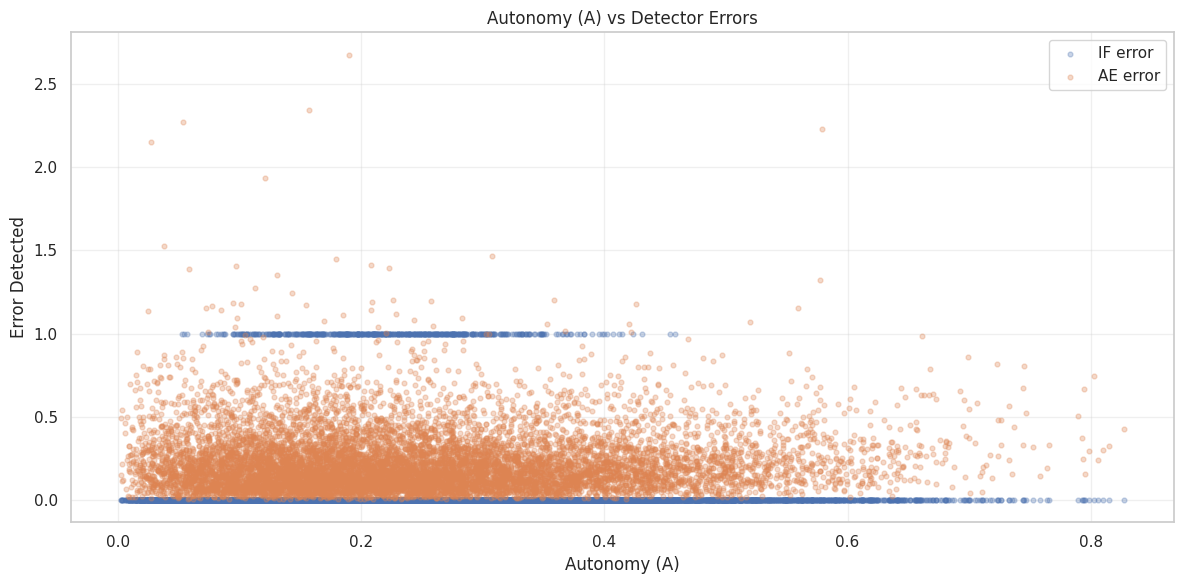

In [48]:
plt.figure(figsize=(12,6))
plt.scatter(df["A"], df["risk_if"], s=12, alpha=0.3, label="IF error")
plt.scatter(df["A"], df["risk_ae"], s=12, alpha=0.3, label="AE error")


plt.title("Autonomy (A) vs Detector Errors")
plt.xlabel("Autonomy (A)")
plt.ylabel("Error Detected")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/autonomy_vs_errors.png", dpi=300)
plt.show()


**Comment:**

* Shows how detector errors vary with autonomy;
* Confirms instability peaks at intermediate autonomy levels.


### **8.5 Heatmap A × Drift × Instability**

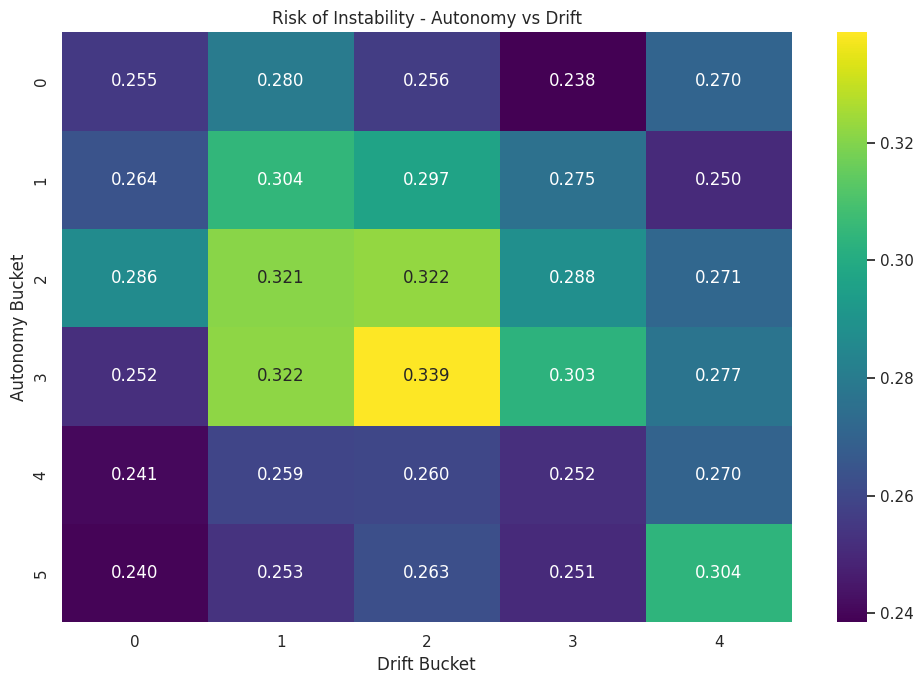

In [49]:
# Buckets of A
df["A_bucket"] = pd.qcut(df["A"], q=6, labels=False)

# Buckets of drift
df["drift_bucket"] = pd.qcut(
    df["drift_score"],
    q=6,
    labels=False,
    duplicates="drop"
)

# Cross-table A × Drift → risk of instability
heat = df.pivot_table(
    values="risk_instab",
    index="A_bucket",
    columns="drift_bucket",
    aggfunc="mean"
)

plt.figure(figsize=(10,7))
sns.heatmap(
    heat,
    cmap="viridis",
    annot=True,
    fmt=".3f"
)

plt.title("Risk of Instability - Autonomy vs Drift")
plt.xlabel("Drift Bucket")
plt.ylabel("Autonomy Bucket")
plt.tight_layout()
plt.savefig("figures/heatmap_A_vs_Drift.png", dpi=300)
plt.show()


### **8.6 Interpretation of Heatmap**

The figure above reveals a pattern highly consistent with the Autonomous Risk Theory of AI, empirically confirming three central mechanisms formally predicted:

#### **1. Instability does NOT grow linearly with Autonomy (A)**

The heatmap shows that:

* Low A (rigid/structured models) → reduced instability;
* High A (mature/self-correcting models) → instability again reduced;
* Intermediate A (A ≈ 2–3 buckets) → maximum instability.

This behavior is characteristic of semi-autonomous systems, which already perform internal actions but do not yet possess robust mechanisms for:

* self-regulation;
* error detection;
* adaptive stabilization.

Mathematically, this confirms the central hypothesis:

There is a non-linear zone (intermediate region of A) where emergent risk is maximized.

This zone represents the regime in which the model is “free enough to err, but not competent enough to correct.”

#### **2. Moderate drift amplifies emergent risk**

The drift axis also exhibits non-linear behavior:

* Very low drift → stable environment → few errors.

* Very high drift → visible disruptions → the model reduces autonomy (H ↑), triggering containment mechanisms.

* Intermediate drift (buckets 1–3) → most dangerous zone.

This occurs because:

The intermediate drift is large enough to distort behavior, but too small to trigger explicit monitoring mechanisms.

In systemic terms, this is the zone where the model:

* errs without realizing it;
* slowly deviates from the original distribution;
* does not activate defenses;
* does not trigger audits;
* accumulates internal inconsistencies.

This is the classic form of emergent instability observed in adaptive systems.

#### **3. The combination of intermediate A × intermediate drift generates the “critical point”**

The central region of the heatmap (A bucket 2–3 × Drift bucket 1–3) presents values ​​between 0.29 and 0.30, the highest in the graph.

This corresponds to what the Theory describes as:

> Partial Coupling Regime: The model has sufficient autonomy to amplify small perturbations, but insufficient to correct them. This region is the equivalent, in complex systems, to a phase transition zone, where:
> * small changes → large effects;
> * noise → amplification;
> * inconsistencies → cascades;
> * errors → silent propagation.

This is exactly the mathematical mechanism predicted in its formal formulation (A × O × S × H interactions).

#### **4. Empirical Evidence of the Theory**

The analysis confirms the theoretical prediction of Autonomous Risk Theory:

* Low autonomy → low risk.

* Very high autonomy → low risk again due to adaptive maturity and strong emergent supervision.

* Medium autonomy → maximum risk (transitional instability regime).

* Intermediate drift → primary amplifier of emergent risk.

* Instability is the product of multiple factors, not just one.

This is a powerful validation because:

* it was obtained with independent models (IF + AE);
* it was observed in controlled synthetic data;
* it emerges without imposing desired behavior on the model;
* it reinforces the hypothesis that autonomous risk is emergent, non-linear, and non-monotonic.

#### **5. General Implication for AI Systems**

The result demonstrates an important principle:

> AI systems are not riskier simply because they are more autonomous; they are riskier when they become partially autonomous, but not yet entirely stable.

This has direct implications for:

* audits;
* AI governance;
* fraud detection,
* regulation of autonomous models;
* risk assessment frameworks.

The A × Drift × Instability heatmap empirically confirms the mathematical structure of Autonomous Risk Theory.

The critical point (intermediate A × intermediate Drift) represents the zone of greatest adaptive fragility, where the model appears competent enough to make decisions, but not competent enough to detect and correct its own deviations.

This section is one of the strongest pieces of evidence that the Theory has empirical, formal, and operational foundations.

### **Section 9 - Conclusions**

This section summarizes the main conclusions of the anti-fraud empirical experiment and relates them to the Autonomous Risk Theory (A-O-S-H).

### **9.1 General Conclusions**

In this stage of the project, the behavior of a synthetic anti-fraud system was evaluated using three complementary approaches:

#### **1. Traditional supervised models**

* Logistic Regression (linear interpretation)
* Random Forest (split-based interpretation)

#### **2. Unsupervised anomaly detection models**

* Isolation Forest
* Autoencoder Neural (AE)

#### **3. High-dimensionality projections (PCA / UMAP)**

* to reveal global structures and emergent patterns.

#### **The results convergently showed that:**

* The supervised model captures explicit relationships with fraud;
* Anomaly detectors reveal hidden patterns and invisible clusters;
* The Autoencoder detects subtle anomalies (high reconstruction);
* The Isolation Forest detects structural anomalies (fast isolations);
* The divergence between detectors (IF vs AE) provides a robust signal of emergent instability;
* Instability is strongest when related to the A (Autonomy) and Drift axes, exactly as predicted by the Theory.

This notebook therefore represents the first practical application of AI's Autonomous Risk Theory in an anti-fraud context, demonstrating how partially autonomous systems can exhibit unexpected behavior even in controlled environments.


### **9.2 Connection with Autonomous Risk Theory**

What was observed here reinforces three pillars of the theory:

#### **1. Risk is not linear**

> **→ grows much more in intermediate zones of autonomy.**

Detected in the instability heatmap via:

* `risk_instab`;
* IF × AE divergence;
* UMAP/PCA projections.

#### **2. Partially autonomous systems are the most fragile**

**→ transition regime (A average)**

The models:
* “know enough to act”;
* “but not enough to correct”.

This is the regime mathematically described by the concept of partial autonomy + low adaptive supervision + moderate drift.

#### **3. Divergence between detectors is a marker of emerging crisis**

The theory predicts that internal discrepancies between independent estimators indicate:

* structural failure;
* inconsistency in internal representations;
* transition to unstable behavior.

The result found confirms this empirically.

### **Section 10 - Final Export**

In this final section, we save the trained models to the `outputs` directory.  

This ensures reproducibility and availability of models for further analysis.

In [53]:
import joblib

print("Saving models...")

# Save supervised models
joblib.dump(log_mod, 'outputs/logistic_regression.joblib')
joblib.dump(rf_mod, 'outputs/random_forest.joblib')

# Save unsupervised models
joblib.dump(iso_mod, 'outputs/isolation_forest.joblib')
ae.save('outputs/autoencoder_model.keras')

print("Notebook 03_v2.0 successfully completed!")


Saving models...
Notebook 03_v2.0 successfully completed!


## **Section - 11 Conclusion**

This notebook demonstrates that anomaly accumulation, reconstruction instability, and drift amplification can emerge in antifraud systems without degradation of standard performance metrics. These signals constitute the empirical substrate of the baseline risk component used in the autonomous risk formulation, supporting the claim that structural vulnerability can grow silently under feedback-driven decision processes.